In [1]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install EoN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.2-py3-none-any.whl size=122468 sha256=f5ccb5621f784d3ac71fb4af91c75a7bfd39cf379e3606a6765e24562ca6e081
  Stored in directory: /root/.cache/pip/wheels/10/ec/88/6daefcc5ebdf7e373db9da6a61386f33143571d885c4c7708a
Successfully built EoN


   SOURCE  TARGET  weight        TIME
0    4667    4676       1  2013-08-06
1    4668    4676       1  2013-08-06
2    4654    4676       1  2013-08-06
3    4667    4677       1  2013-08-06
4    1810    4677     -10  2013-08-06
2187
9903


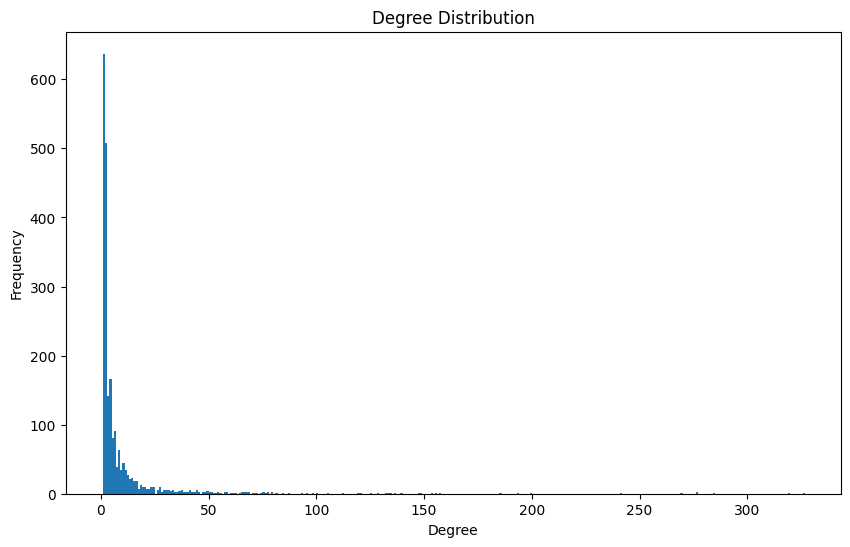

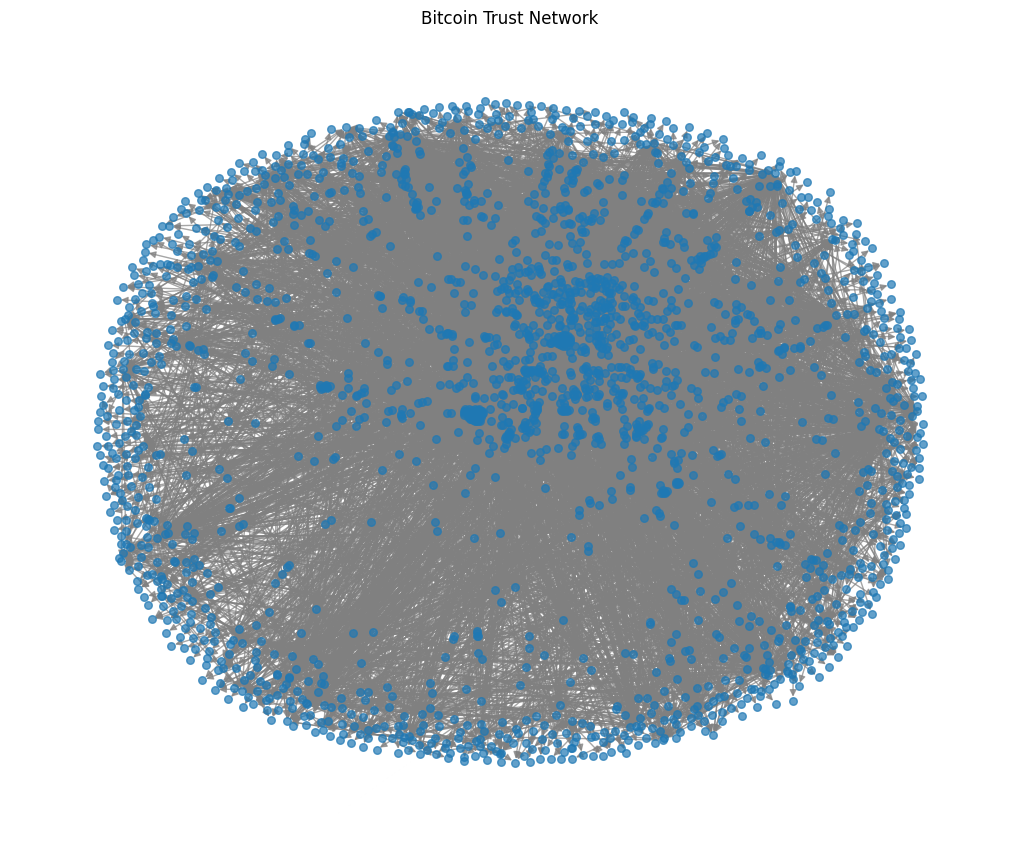

Average Transmission Rate (tau): 0.5085
Average Recovery Rate (gamma): 0.4915
2177
2177


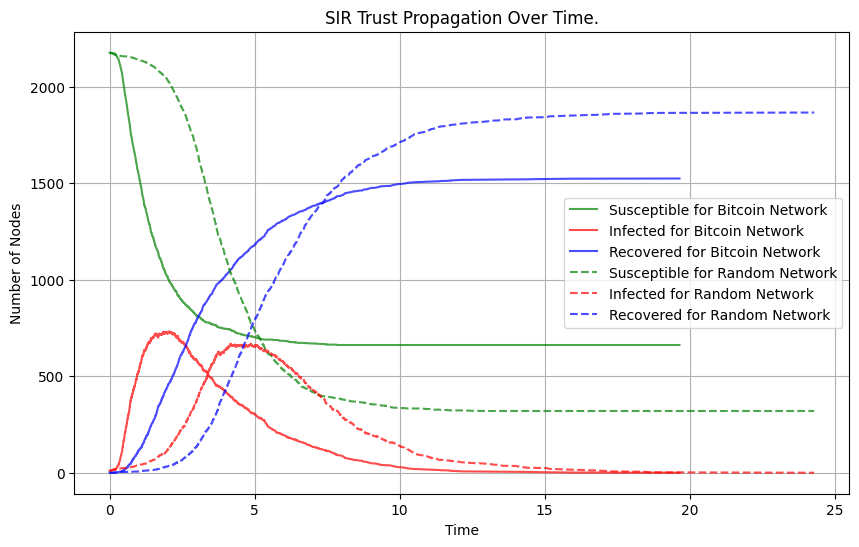

In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import EoN
import pandas as pd

# -----------------------------------
# Load and Prepare the Dataset
# -----------------------------------
df = pd.read_csv('/content/drive/MyDrive/filtered_soc-sign-bitcoinotc.csv')
df = df.rename(columns={'RATING': 'weight'}) #the name of the column is changed from 'RATING' to 'weight'
print(df.head())


#Create a directed, weighted trust graph
G = nx.from_pandas_edgelist(df, source='SOURCE', target='TARGET', edge_attr='weight', create_using=nx.DiGraph())
print(G.number_of_nodes())
print(G.number_of_edges())

total_degrees = [deg for node, deg in G.degree()]
plt.figure(figsize=(10,6))
plt.hist(total_degrees,bins=range(max(total_degrees)+2))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
# Visualize the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, with_labels=False, node_size=30, edge_color='gray', alpha=0.7)
plt.title("Bitcoin Trust Network")
plt.show()

# -----------------------------------
# Normalize and Compute Transmission & Recovery Rates
# -----------------------------------
min_rating = df["weight"].min() #minimum trust rating
max_rating = df["weight"].max() #maximum trust rating

# Normalize trust values to [0, 1]
df["transmission_rate"] = np.clip((df["weight"] - min_rating) / (max_rating - min_rating), 0, 1) #min max normalisation to find the transmission rates.
df["recovery_rate"] = 1 - df["transmission_rate"]

# Use average rates for global parameters
average_tau = df["transmission_rate"].mean() #constant transmission rate is given by the average of all transmission rates
average_gamma = df["recovery_rate"].mean()  #constant recovery rate is given by the average of all recovery rates

print(f"Average Transmission Rate (tau): {average_tau:.4f}")
print(f"Average Recovery Rate (gamma): {average_gamma:.4f}")

# -----------------------------------
# Run the SIR Simulation
# -----------------------------------

# Run SIR model using EoN


t,S,I,R= EoN.fast_SIR(
    G,
    tau=average_tau,
    gamma=average_gamma,
    rho=(10/2187),
    tmax=50
)

H=nx.gnm_random_graph(2187,9903,directed=True) #generates a directed Erdos-renyi random network with 2187 nodes and 9903 edges.

t2,S2,I2,R2= EoN.fast_SIR(      #SIR simulation, tmax=100 means that the simulation will stop after no more than 100 time steps.
    H,
    tau=average_tau,
    gamma=average_gamma,
    rho=(10/2187),
    tmax=50)
print(S[0])
print(S2[0])
# Epidemic Curve which plots the number of nodes at each stage (susceptible, infected, recovered) since the beginning of time.
plt.figure(figsize=(10, 6))
plt.plot(t, S, label="Susceptible for Bitcoin Network",alpha=0.7, color='green')
plt.plot(t, I, label="Infected for Bitcoin Network",alpha=0.7, color='red')
plt.plot(t, R, label="Recovered for Bitcoin Network",alpha=0.7, color='blue')
plt.xlabel("Time")
plt.ylabel("Number of Nodes")
plt.title("SIR Trust Propagation Over Time.")
plt.plot(t2, S2, label="Susceptible for Random Network",alpha=0.7,linestyle='dashed', color='green')
plt.plot(t2, I2, label="Infected for Random Network",alpha=0.7,linestyle='dashed', color='red')
plt.plot(t2, R2, label="Recovered for Random Network",alpha=0.7,linestyle='dashed', color='blue')
plt.legend()
plt.grid(True)
plt.show()

# The number of susceptible nodes reduced at a faster rate for the Bitcoin Net compared to the random net, from the start to t=2.5. as shown be the curve of the Bitcoin Net having a steeper gradient. The number of susceptible nodes reduced to less than 750 from 2177 within the first five time steps.
# The number of infected nodes for both graphs increase to about 800 in the first 2.5 time steps, before decreasing to 0 by time step 20.
# The number of recovered nodes plateaued at slightly over 1500 for the Bitcoin network, but plateaued at close to 1900 for the random network. The number of recovered nodes no longer increased after.
